In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(theme='onedork')
import torch
from torch import nn, optim, utils
import torch.backends.cudnn as cudnn
import torchvision.datasets as vdatasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import os
import time
from tqdm import tqdm
import copy

In [2]:
data_dir = '/home/samael/github/image_generation/'
worker = 2
batch_size = 128
image_size = 224
num_epochs = 100
lr = 1e-2
momentum = 0.9
ngpu = 1

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: vdatasets.ImageFolder(os.path.join(
    data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(
    image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

Initializing Datasets and Dataloaders...


In [4]:
device = torch.device('cuda:0')

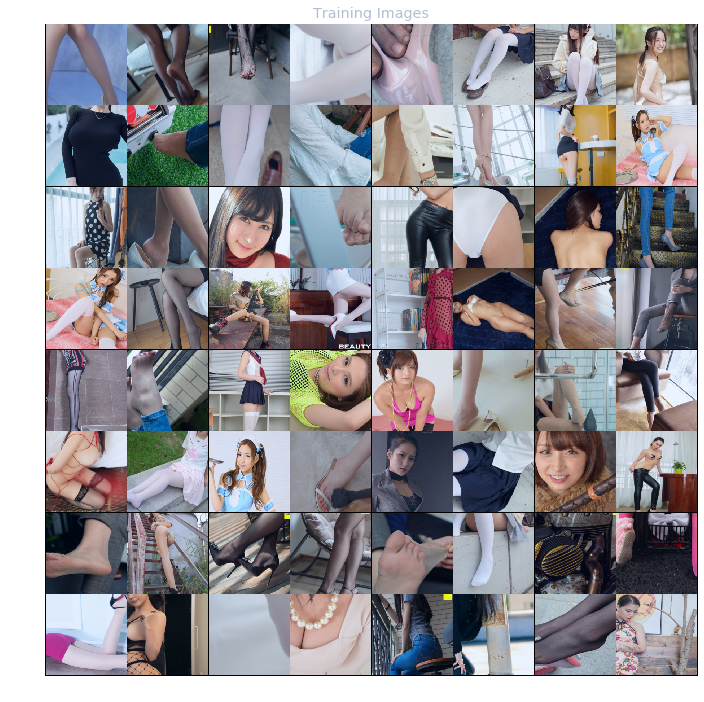

In [5]:
real_batch = next(iter(dataloaders_dict['train']))
plt.figure(figsize=(12, 12))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [6]:
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride,
                     padding=1, bias=False)

def conv1x1(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)

In [7]:
class BasicBlock(nn.Module):
    expansion = 1
    
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
    
    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
            
        out += identity
        out = self.relu(out)
        
        return out

In [8]:
class Bottleneck(nn.Module):
    expansion = 4
    
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
            
        out += identity
        out = self.relu(out)
        return out

In [9]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes, zero_init_residual=False):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion)
            )
        
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x

In [10]:
resnet18 = ResNet(BasicBlock, [2, 2, 2, 2], 7)
resnet18 = resnet18.to(device)

In [11]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    since = time.time()
    val_acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_correct = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_correct += torch.sum(preds == labels.data)
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_correct.double() / len(dataloaders[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
        print()
        
    time_elapsed = time.time() - since
    hour = time_elapsed // 3600
    minute = (time_elapsed - hour * 3600) // 60
    second = (time_elapsed - hour * 3600) % 60
    print("Training complete in {:.0f}h {:.0f}m {:.0f}s".format(hour, minute, second))
    
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [12]:
optimizer_ft = optim.SGD(resnet18.parameters(), lr=lr, momentum=momentum)
criterion = nn.CrossEntropyLoss()

In [13]:
model_ft, hist = train_model(resnet18, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 1/100
----------
train Loss: 1.6174 Acc: 0.3489
val Loss: 2.6738 Acc: 0.1934

Epoch 2/100
----------
train Loss: 1.3998 Acc: 0.4735
val Loss: 2.5627 Acc: 0.3130

Epoch 3/100
----------
train Loss: 1.2145 Acc: 0.5533
val Loss: 3.6369 Acc: 0.1628

Epoch 4/100
----------
train Loss: 1.0871 Acc: 0.5981
val Loss: 2.3014 Acc: 0.3359

Epoch 5/100
----------
train Loss: 1.0201 Acc: 0.6300
val Loss: 2.3716 Acc: 0.3588

Epoch 6/100
----------
train Loss: 0.9657 Acc: 0.6429
val Loss: 1.9863 Acc: 0.4377

Epoch 7/100
----------
train Loss: 0.9250 Acc: 0.6645
val Loss: 2.8869 Acc: 0.3410

Epoch 8/100
----------
train Loss: 0.8573 Acc: 0.6831
val Loss: 3.2071 Acc: 0.3537

Epoch 9/100
----------
train Loss: 0.8729 Acc: 0.6775
val Loss: 2.8724 Acc: 0.2875

Epoch 10/100
----------
train Loss: 0.8034 Acc: 0.7037
val Loss: 2.8035 Acc: 0.4555

Epoch 11/100
----------
train Loss: 0.7663 Acc: 0.7177
val Loss: 3.1948 Acc: 0.4097

Epoch 12/100
----------
train Loss: 0.7588 Acc: 0.7213
val Loss: 4.0919 Ac

KeyboardInterrupt: 